In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%pip install unidecode
from unidecode import unidecode

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Define o diretório em que o csv está localizado
PATH_RESOURCES = os.path.join(os.path.dirname(os.getcwd()), "resources/data/")
# Define o diretório em que as imagens serão salvas
PATH_IMAGES = os.path.join(os.path.dirname(os.getcwd()), "resources/images/")

if PATH_RESOURCES not in os.getcwd():
    os.makedirs(PATH_RESOURCES, exist_ok=True)

if PATH_IMAGES not in os.getcwd():
    os.makedirs(PATH_IMAGES, exist_ok=True)

if not os.path.exists(os.path.join(PATH_RESOURCES, "dados_logisticos_sinteticos.csv")):
    raise FileNotFoundError("O arquivo 'dados_logisticos_sinteticos.csv' não foi encontrado no diretório especificado. Por favor, gere o arquivo antes de continuar.")

df = pd.read_csv(os.path.join(PATH_RESOURCES, "dados_logisticos_sinteticos.csv"))

df["data_hora_pedido"] = pd.to_datetime(df["data_hora_pedido"])

In [3]:
# amostragem segmentada
def get_stratified_sample(
    data, strata_column, sample_size_percent=0.3, random_state=42
):
    strata = data[strata_column].unique()
    sampled_data = pd.DataFrame()

    for stratum in strata:
        stratum_data = data[data[strata_column] == stratum]
        stratum_sample_size = int(len(stratum_data) * sample_size_percent)
        stratum_sample = stratum_data.sample(
            n=stratum_sample_size, random_state=random_state
        )
        sampled_data = pd.concat([sampled_data, stratum_sample])

    return sampled_data

In [4]:
# Realizar amostragem estratificada (30% dos dados)
df_sampled = get_stratified_sample(df, "centro_distribuicao")
df = df_sampled
df["mes_ano"] = df["data_hora_pedido"].dt.strftime("%Y-%m")
df["mes_ano"] = pd.to_datetime(df["mes_ano"])
df.sort_values("mes_ano", inplace=True)


-----------------------------------------------------------------------------------------------------
Gráfico 1: Ocupação Média dos Centros de Distribuição por Mês/Ano
Este gráfico mostra a ocupação média de cada centro de distribuição ao longo dos meses/anos.
Ele ajuda a identificar sazonalidades e períodos críticos de alta ocupação em cada CD.
-----------------------------------------------------------------------------------------------------
    

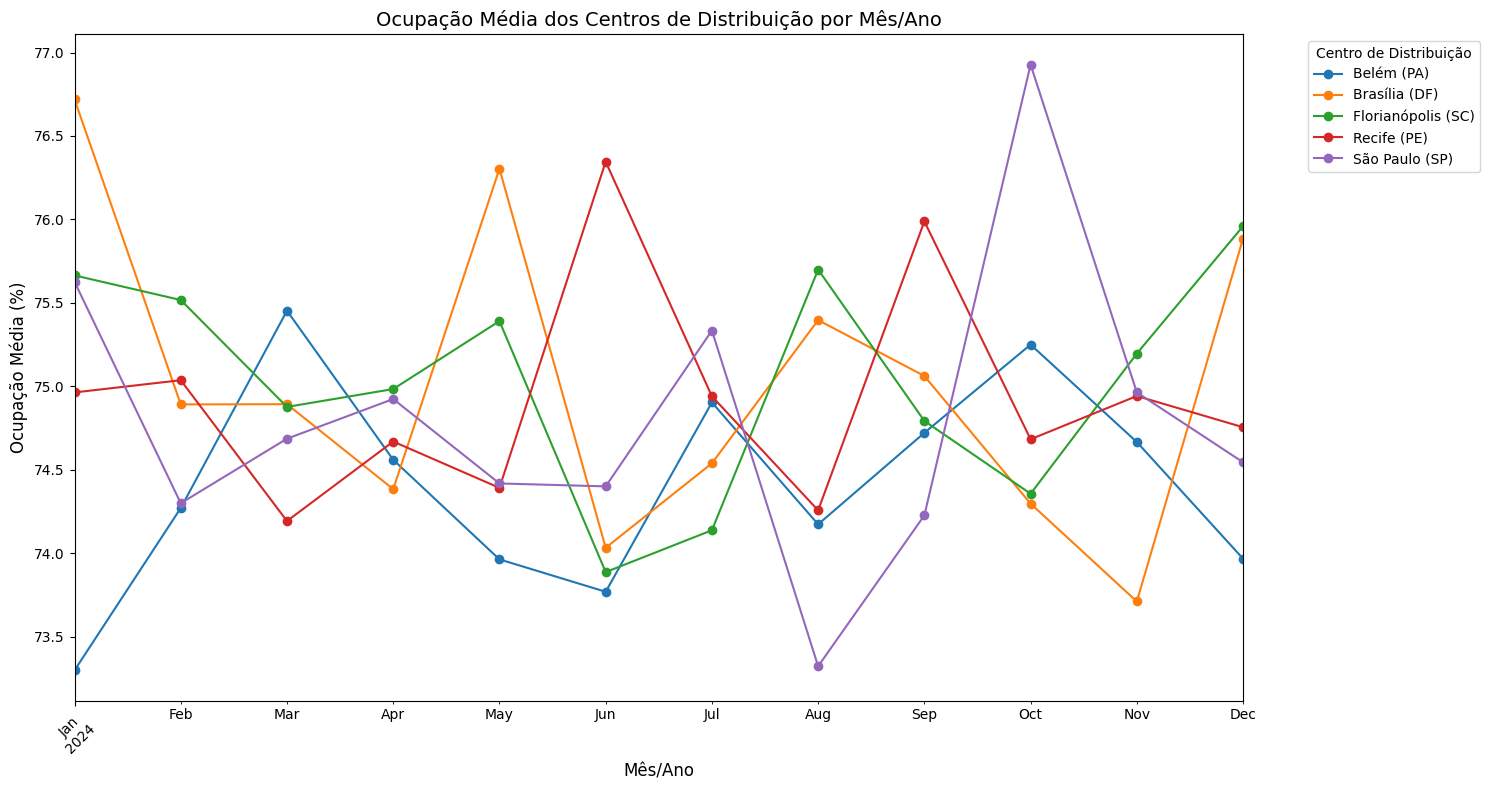

In [5]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 1: Ocupação Média dos Centros de Distribuição por Mês/Ano
Este gráfico mostra a ocupação média de cada centro de distribuição ao longo dos meses/anos.
Ele ajuda a identificar sazonalidades e períodos críticos de alta ocupação em cada CD.
-----------------------------------------------------------------------------------------------------
    """,
    end="",
)
grouped_data = (
    df.groupby(["mes_ano", "centro_distribuicao"])["percentual_ocupacao_CD"]
    .mean()
    .unstack()
)
fig, ax = plt.subplots(figsize=(15, 8))
grouped_data.plot(kind="line", marker="o", ax=ax)
ax.set_title("Ocupação Média dos Centros de Distribuição por Mês/Ano", fontsize=14)
ax.set_xlabel("Mês/Ano", fontsize=12)
ax.set_ylabel("Ocupação Média (%)", fontsize=12)
ax.legend(title="Centro de Distribuição", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "ocupacao_media_cd_por_mes.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 2: Heatmap de correlações entre variáveis relacionadas a atrasos
Este gráfico mostra as correlações entre variáveis como tempo total de processamento,
atraso no transporte e quantidade de itens. Ele ajuda a identificar relações entre essas variáveis.
-----------------------------------------------------------------------------------------------------


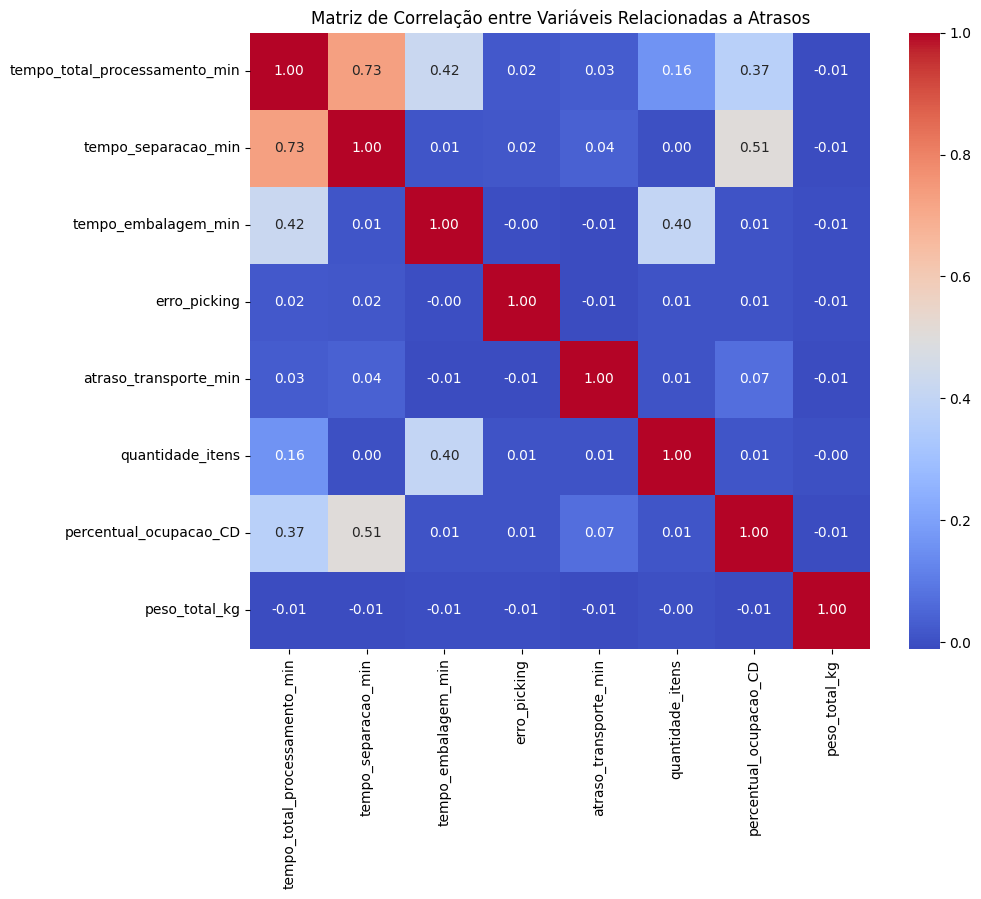

In [11]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 2: Heatmap de correlações entre variáveis relacionadas a atrasos
Este gráfico mostra as correlações entre variáveis como tempo total de processamento,
atraso no transporte e quantidade de itens. Ele ajuda a identificar relações entre essas variáveis.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)
correlation_matrix = df[
    [
        "tempo_total_processamento_min",
        "tempo_separacao_min",
        "tempo_embalagem_min",
        "erro_picking",
        "atraso_transporte_min",
        "quantidade_itens",
        "percentual_ocupacao_CD",
        "peso_total_kg",
    ]
].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação entre Variáveis Relacionadas a Atrasos")
plt.savefig(
    os.path.join(PATH_IMAGES, "matriz_correlacao_atrasos.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 3: Boxplot de atrasos por centro de distribuição
Este gráfico mostra a distribuição dos atrasos no transporte para cada centro de distribuição.
Ele ajuda a identificar quais CDs têm maior variação ou problemas relacionados a atrasos.
-----------------------------------------------------------------------------------------------------


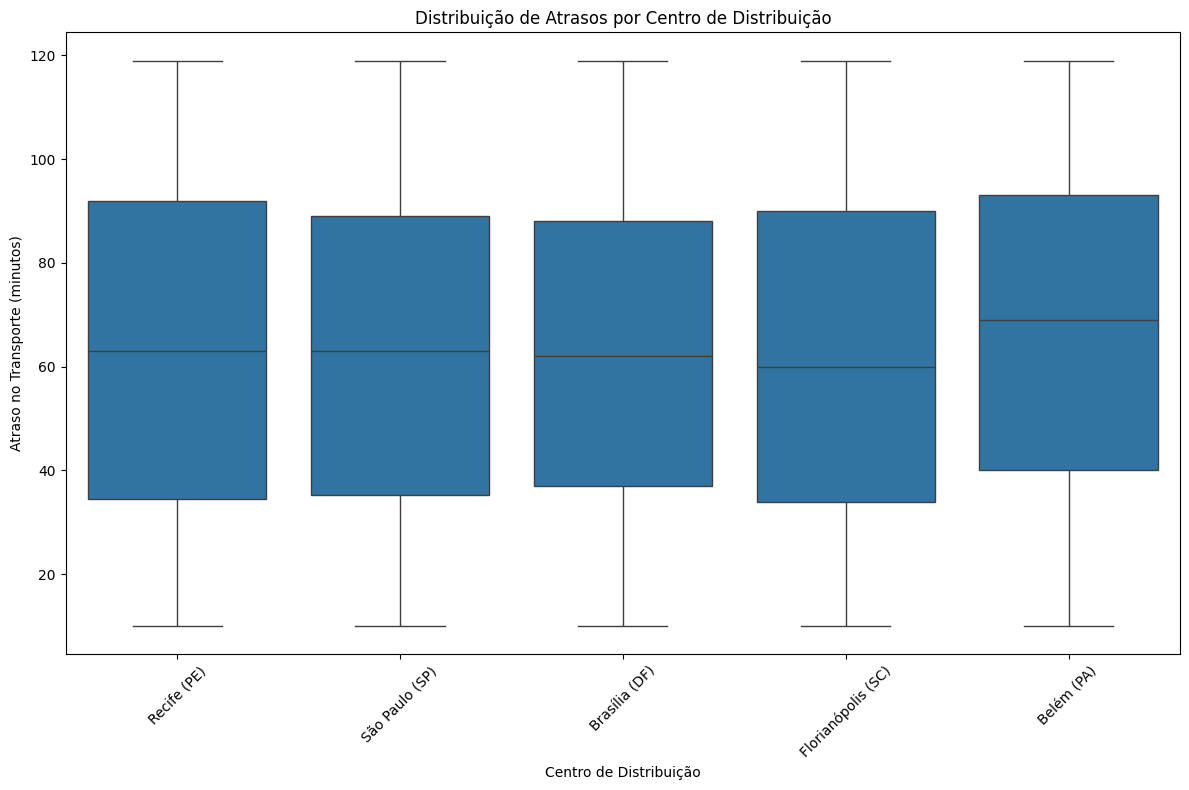

In [12]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 3: Boxplot de atrasos por centro de distribuição
Este gráfico mostra a distribuição dos atrasos no transporte para cada centro de distribuição.
Ele ajuda a identificar quais CDs têm maior variação ou problemas relacionados a atrasos.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df[df["status_pedido"] == "Atrasado"],
    x="centro_distribuicao",
    y="atraso_transporte_min",
)
plt.title("Distribuição de Atrasos por Centro de Distribuição")
plt.xlabel("Centro de Distribuição")
plt.ylabel("Atraso no Transporte (minutos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "distribuicao_atrasos_por_cd.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 4: Boxplots para Variáveis Críticas
Este gráfico exibe boxplots das variáveis relacionadas ao tempo e ocupação.
-----------------------------------------------------------------------------------------------------


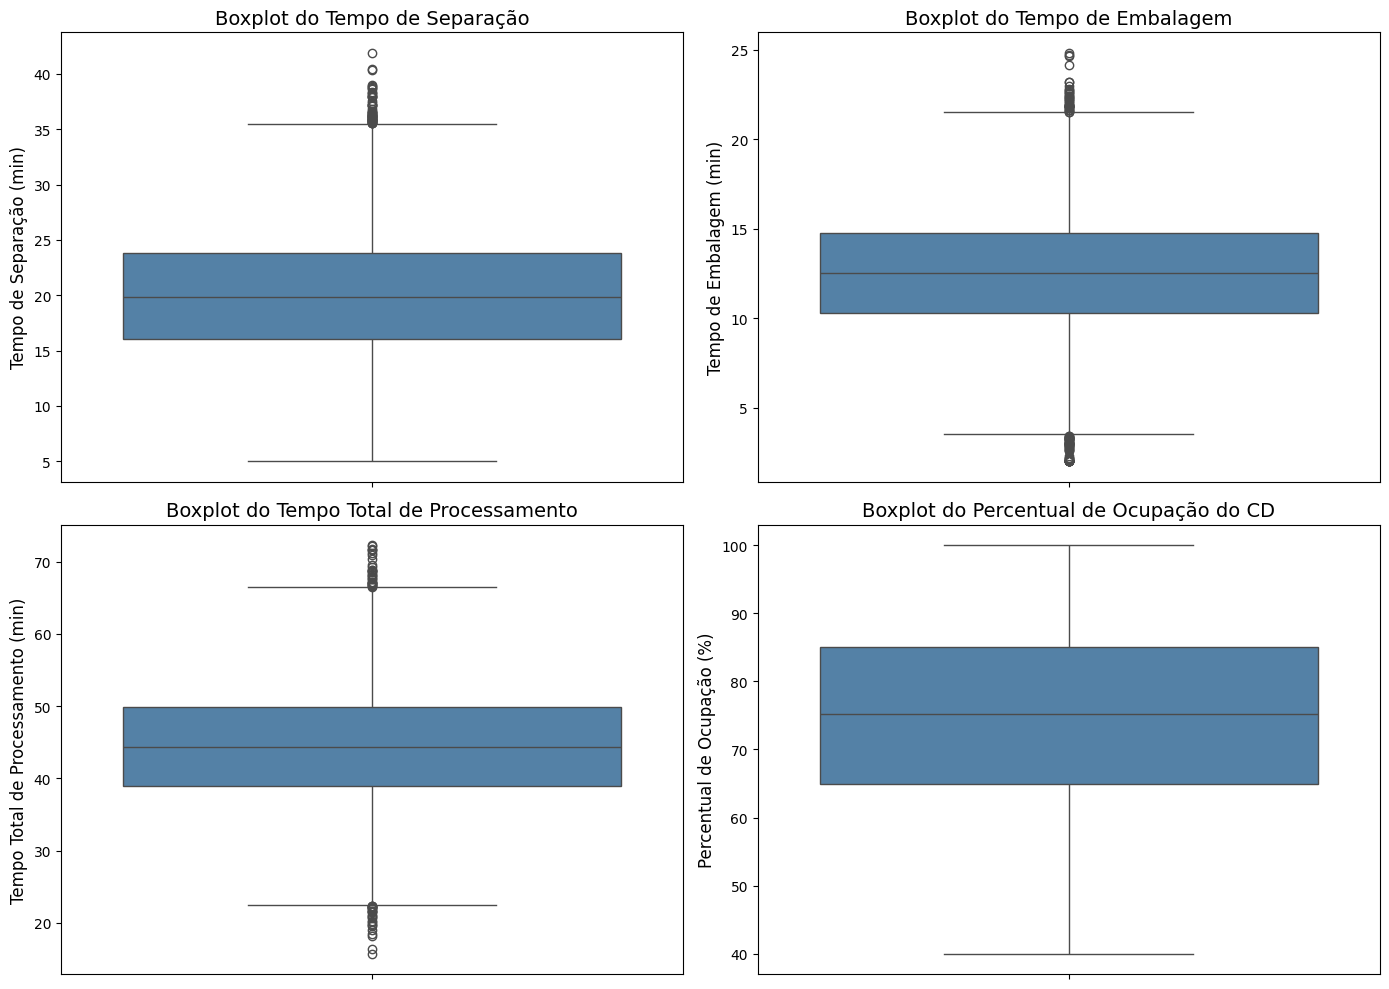

In [13]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 4: Boxplots para Variáveis Críticas
Este gráfico exibe boxplots das variáveis relacionadas ao tempo e ocupação.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.boxplot(
    ax=axes[0, 0],
    y=df["tempo_separacao_min"],
    color="steelblue",
)
axes[0, 0].set_title("Boxplot do Tempo de Separação", fontsize=14)
axes[0, 0].set_ylabel("Tempo de Separação (min)", fontsize=12)
axes[0, 0].tick_params(axis="y", labelsize=10)

sns.boxplot(
    ax=axes[0, 1],
    y=df["tempo_embalagem_min"],
    color="steelblue",
)
axes[0, 1].set_title("Boxplot do Tempo de Embalagem", fontsize=14)
axes[0, 1].set_ylabel("Tempo de Embalagem (min)", fontsize=12)
axes[0, 1].tick_params(axis="y", labelsize=10)

sns.boxplot(
    ax=axes[1, 0],
    y=df["tempo_total_processamento_min"],
    color="steelblue",
)
axes[1, 0].set_title("Boxplot do Tempo Total de Processamento", fontsize=14)
axes[1, 0].set_ylabel("Tempo Total de Processamento (min)", fontsize=12)
axes[1, 0].tick_params(axis="y", labelsize=10)

sns.boxplot(
    ax=axes[1, 1],
    y=df["percentual_ocupacao_CD"],
    color="steelblue",
)
axes[1, 1].set_title("Boxplot do Percentual de Ocupação do CD", fontsize=14)
axes[1, 1].set_ylabel("Percentual de Ocupação (%)", fontsize=12)
axes[1, 1].tick_params(axis="y", labelsize=10)
fig.tight_layout()
plt.savefig(os.path.join(PATH_IMAGES, "boxplots_variaveis_criticas.png"), dpi=300)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 5: Análise dos itens mais atrasados por categoria
Este gráfico mostra quais categorias de produtos têm O maior número absoluto de pedidos atrasados.
Ele ajuda a entender quais tipos de produtos enfrentam mais problemas logísticos.
-----------------------------------------------------------------------------------------------------


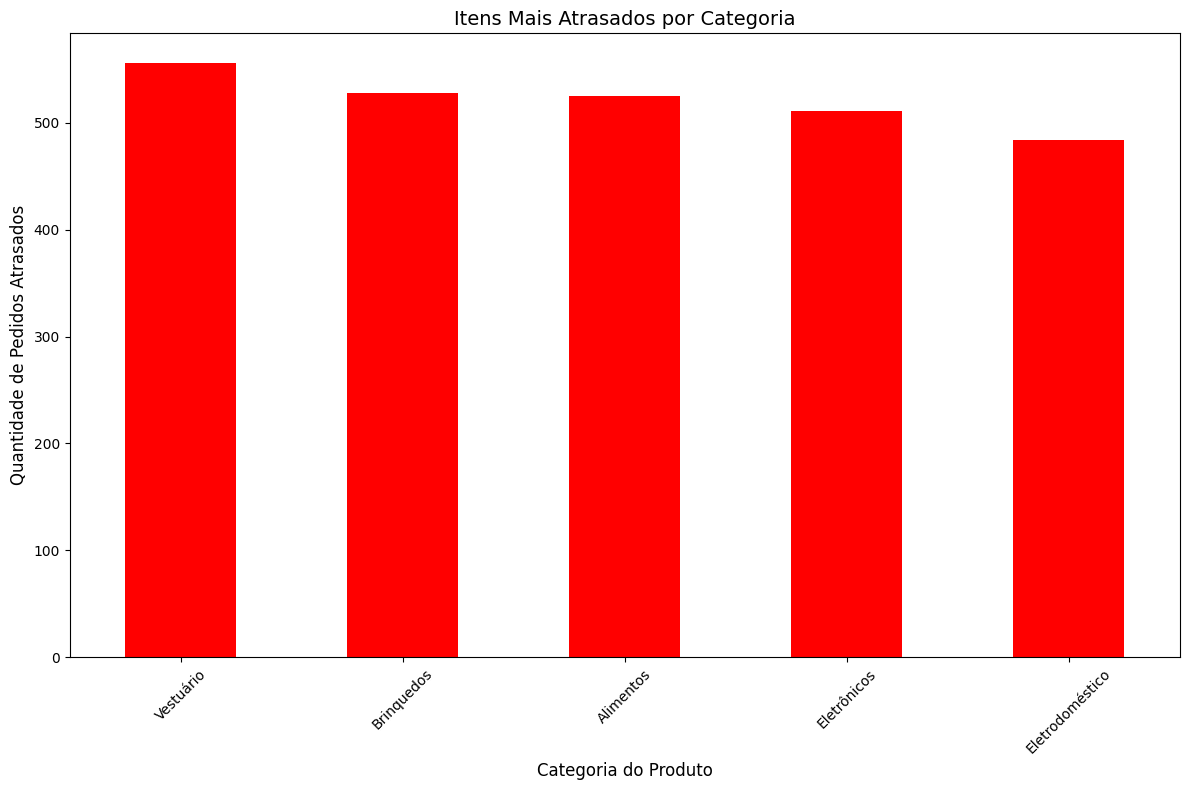

In [14]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 5: Análise dos itens mais atrasados por categoria
Este gráfico mostra quais categorias de produtos têm O maior número absoluto de pedidos atrasados.
Ele ajuda a entender quais tipos de produtos enfrentam mais problemas logísticos.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)
itens_atrasados = (
    df[df["status_pedido"] == "Atrasado"]
    .groupby("categoria_produto")["id_pedido"]
    .count()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 8))
itens_atrasados.plot(kind="bar", color="red")
plt.title("Itens Mais Atrasados por Categoria", fontsize=14)
plt.xlabel("Categoria do Produto", fontsize=12)
plt.ylabel("Quantidade de Pedidos Atrasados", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "itens_atrasados_por_categoria.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 6: Scatterplot da relação entre ocupação do CD e atrasos no transporte
Este gráfico mostra como a ocupação do CD está relacionada aos atrasos no transporte,
com destaque para cada centro de distribuição. Ele ajuda a entender se CDs mais ocupados 
têm maior probabilidade de gerar atrasos.
-----------------------------------------------------------------------------------------------------


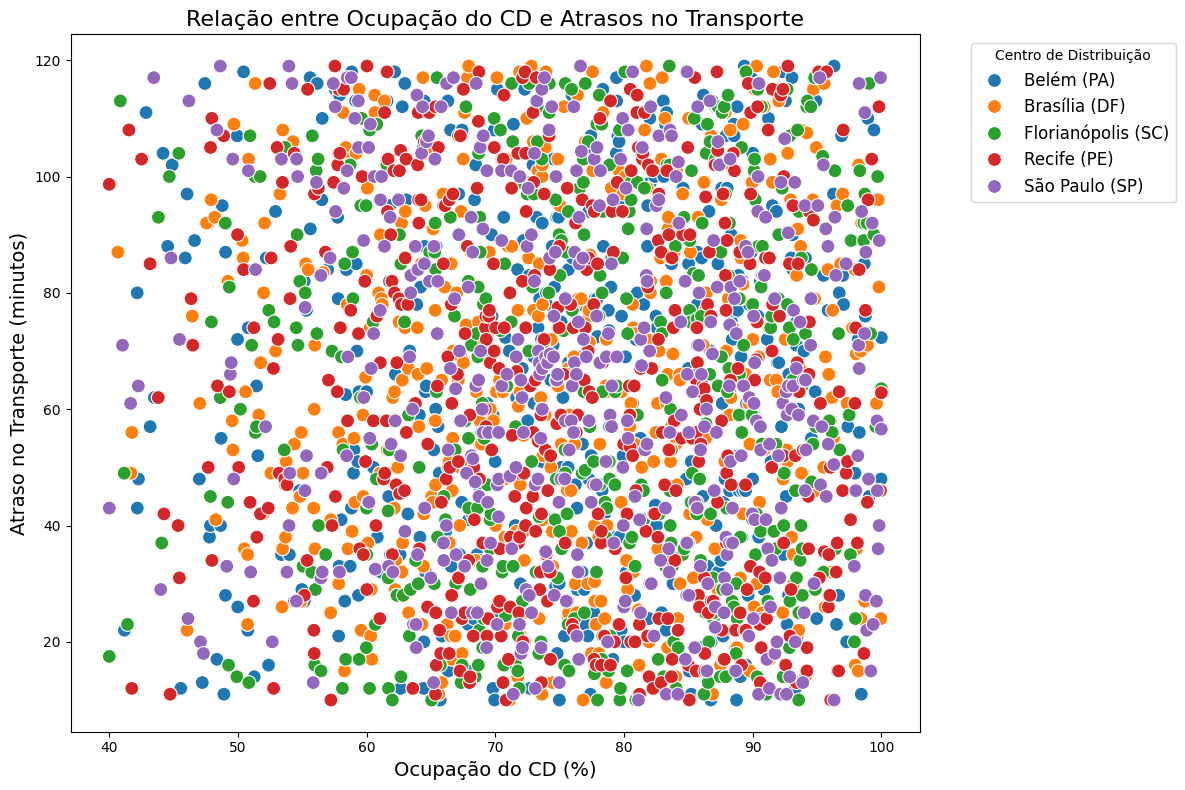

In [15]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 6: Scatterplot da relação entre ocupação do CD e atrasos no transporte
Este gráfico mostra como a ocupação do CD está relacionada aos atrasos no transporte,
com destaque para cada centro de distribuição. Ele ajuda a entender se CDs mais ocupados 
têm maior probabilidade de gerar atrasos.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)


df_atrasados = df[df["status_pedido"] == "Atrasado"]
df_grouped = df_atrasados.groupby(
    ["centro_distribuicao", "percentual_ocupacao_CD"], as_index=False
).agg({"atraso_transporte_min": "mean"})
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_grouped,
    x="percentual_ocupacao_CD",
    y="atraso_transporte_min",
    hue="centro_distribuicao",
    s=100,
)
plt.title("Relação entre Ocupação do CD e Atrasos no Transporte", fontsize=16)
plt.xlabel("Ocupação do CD (%)", fontsize=14)
plt.ylabel("Atraso no Transporte (minutos)", fontsize=14)
plt.legend(
    title="Centro de Distribuição",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12,
)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "relacao_ocupacao_atrasos.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráficos 7: Relação de Categorias de maior atraso por centro de distribuição
Este gráfico mostra as categorias que possuem maior atraso por CD.
Ele ajuda a identificar as categorias mais agravantes em relação ao atraso como um todo. 
-----------------------------------------------------------------------------------------------------
    

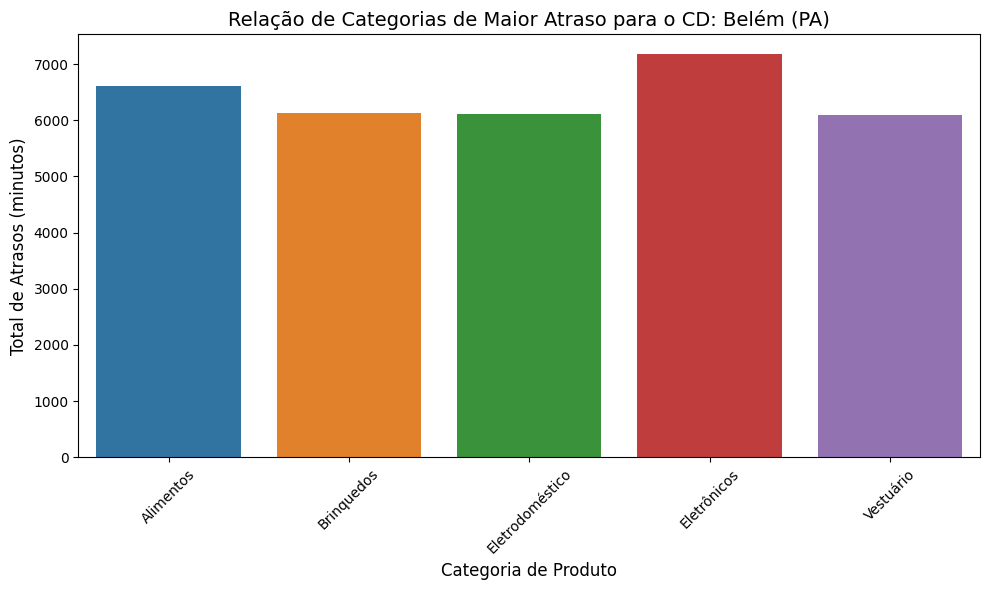

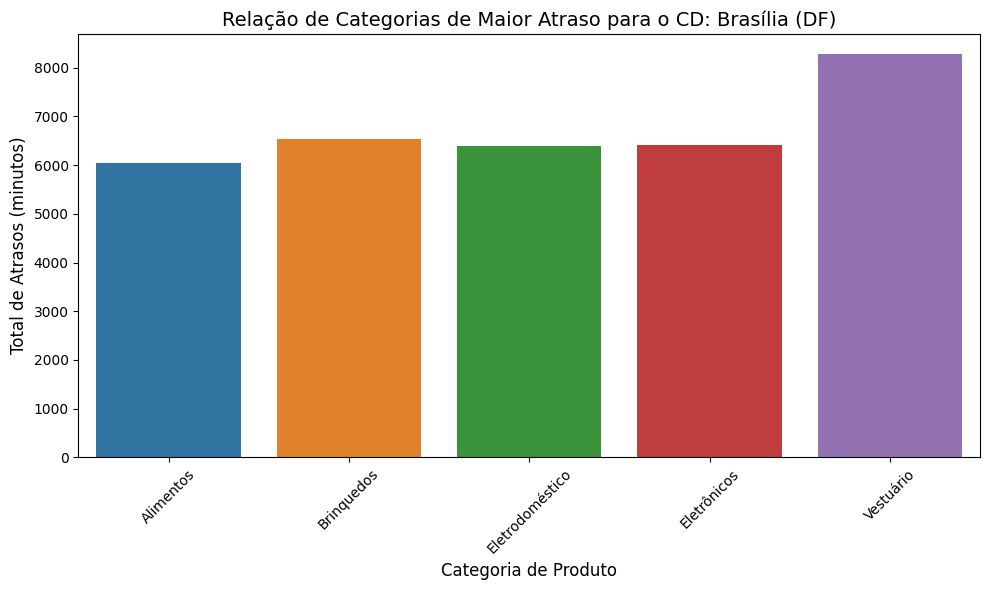

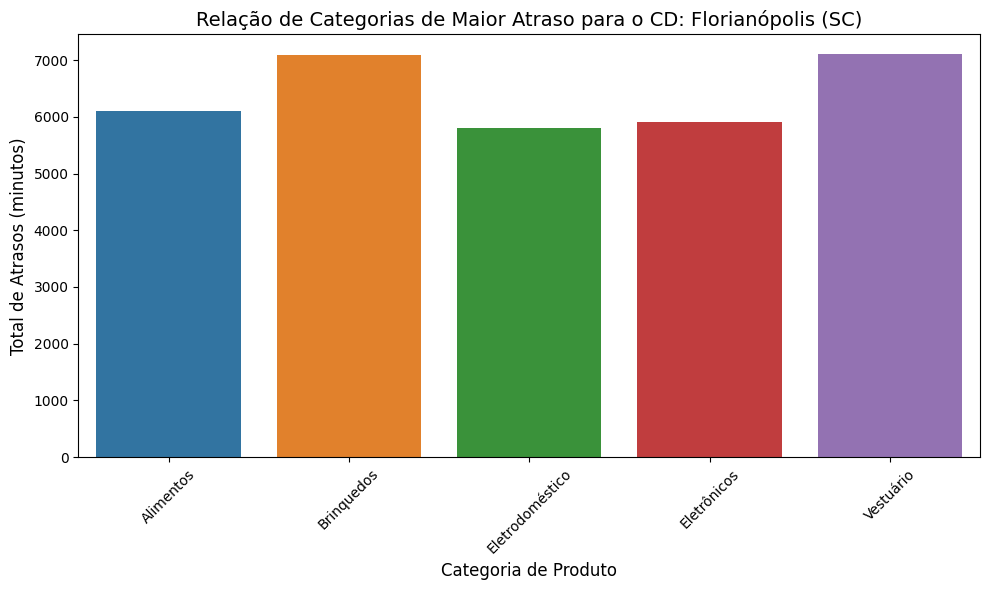

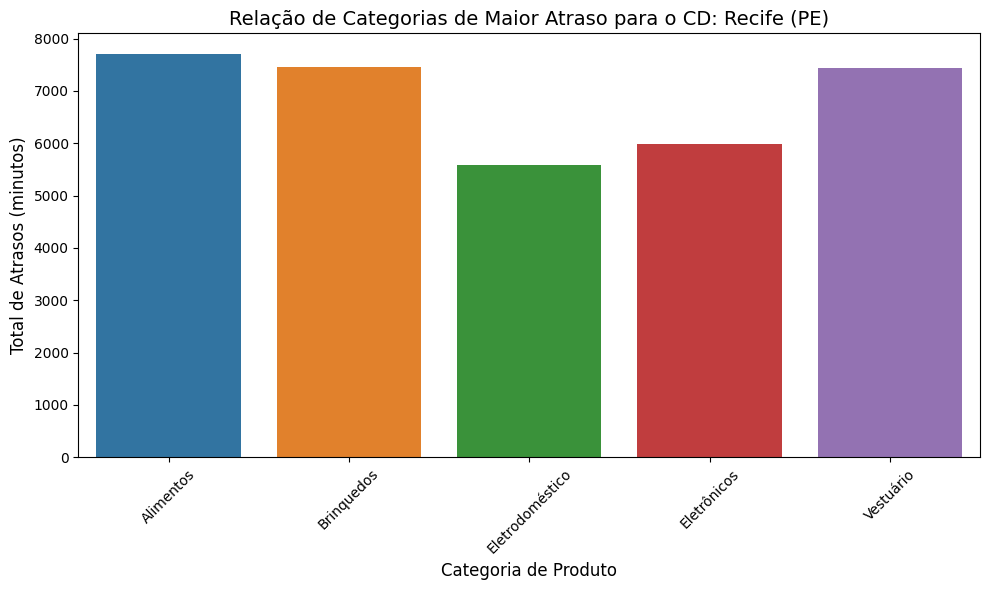

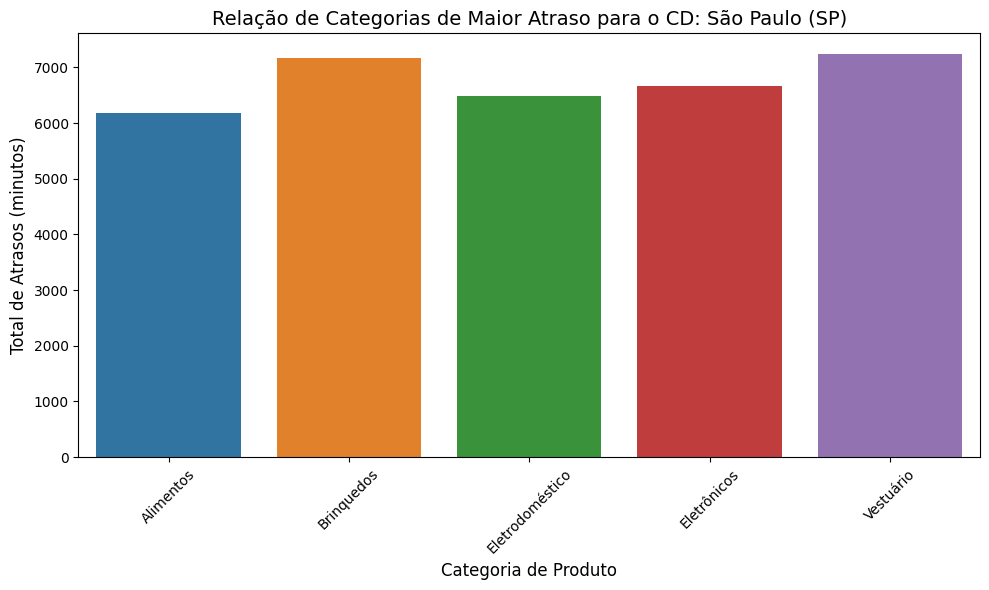

In [16]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráficos 7: Relação de Categorias de maior atraso por centro de distribuição
Este gráfico mostra as categorias que possuem maior atraso por CD.
Ele ajuda a identificar as categorias mais agravantes em relação ao atraso como um todo. 
-----------------------------------------------------------------------------------------------------
    """,
    end="",
)

df_atrasados = df[df["status_pedido"] == "Atrasado"]
df_grouped_cd_category = (
    df_atrasados.groupby(["centro_distribuicao", "categoria_produto"])
    .agg({"atraso_transporte_min": "sum"})
    .reset_index()
)
cds = df_grouped_cd_category["centro_distribuicao"].unique()
for cd in cds:
    plt.figure(figsize=(10, 6))
    cd_data = df_grouped_cd_category[
        df_grouped_cd_category["centro_distribuicao"] == cd
    ]
    cd_nome_formatado = unidecode(cd)
    sns.barplot(
        data=cd_data,
        x="categoria_produto",
        y="atraso_transporte_min",
        hue="categoria_produto",
    )
    plt.title(f"Relação de Categorias de Maior Atraso para o CD: {cd}", fontsize=14)
    plt.xlabel("Categoria de Produto", fontsize=12)
    plt.ylabel("Total de Atrasos (minutos)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            PATH_IMAGES,
            f"relacao_categorias_atraso_{cd_nome_formatado.replace(' ', '_')}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 8: Ocupação Média dos Centros de Distribuição por Mês/Ano
Este gráfico mostra a ocupação média de cada centro de distribuição ao longo dos meses/anos.
Ele ajuda a identificar sazonalidades e períodos críticos de alta ocupação em cada CD.
-----------------------------------------------------------------------------------------------------
    

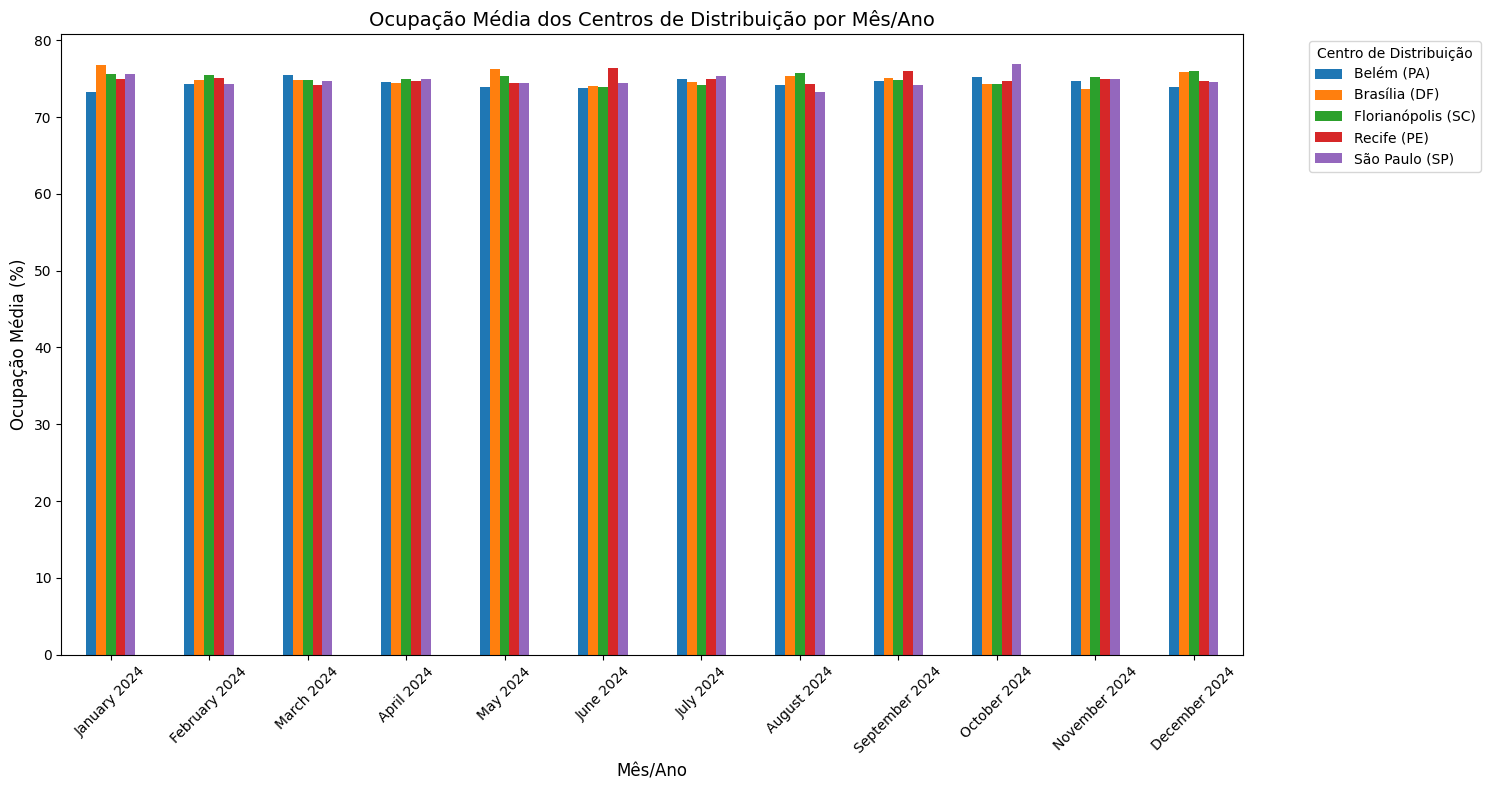

In [26]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 8: Ocupação Média dos Centros de Distribuição por Mês/Ano
Este gráfico mostra a ocupação média de cada centro de distribuição ao longo dos meses/anos.
Ele ajuda a identificar sazonalidades e períodos críticos de alta ocupação em cada CD.
-----------------------------------------------------------------------------------------------------
    """,
    end="",
)
grouped_data = (
    df.groupby(["mes_ano", "centro_distribuicao"])["percentual_ocupacao_CD"]
    .mean()
    .unstack()
)
grouped_data.index = grouped_data.index.strftime("%B %Y")
fig, ax = plt.subplots(figsize=(15, 8))
grouped_data.plot(kind="bar", ax=ax)
ax.set_title("Ocupação Média dos Centros de Distribuição por Mês/Ano", fontsize=14)
ax.set_xlabel("Mês/Ano", fontsize=12)
ax.set_ylabel("Ocupação Média (%)", fontsize=12)
ax.legend(title="Centro de Distribuição", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "ocupacao_media_por_mes_ano_barras.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


-----------------------------------------------------------------------------------------------------
Gráfico 9: Quantidade total de itens transportados por categoria
Este gráfico mostra o volume total transportado para cada categoria de produto.
Ele ajuda a identificar quais categorias têm maior demanda logística.
-----------------------------------------------------------------------------------------------------


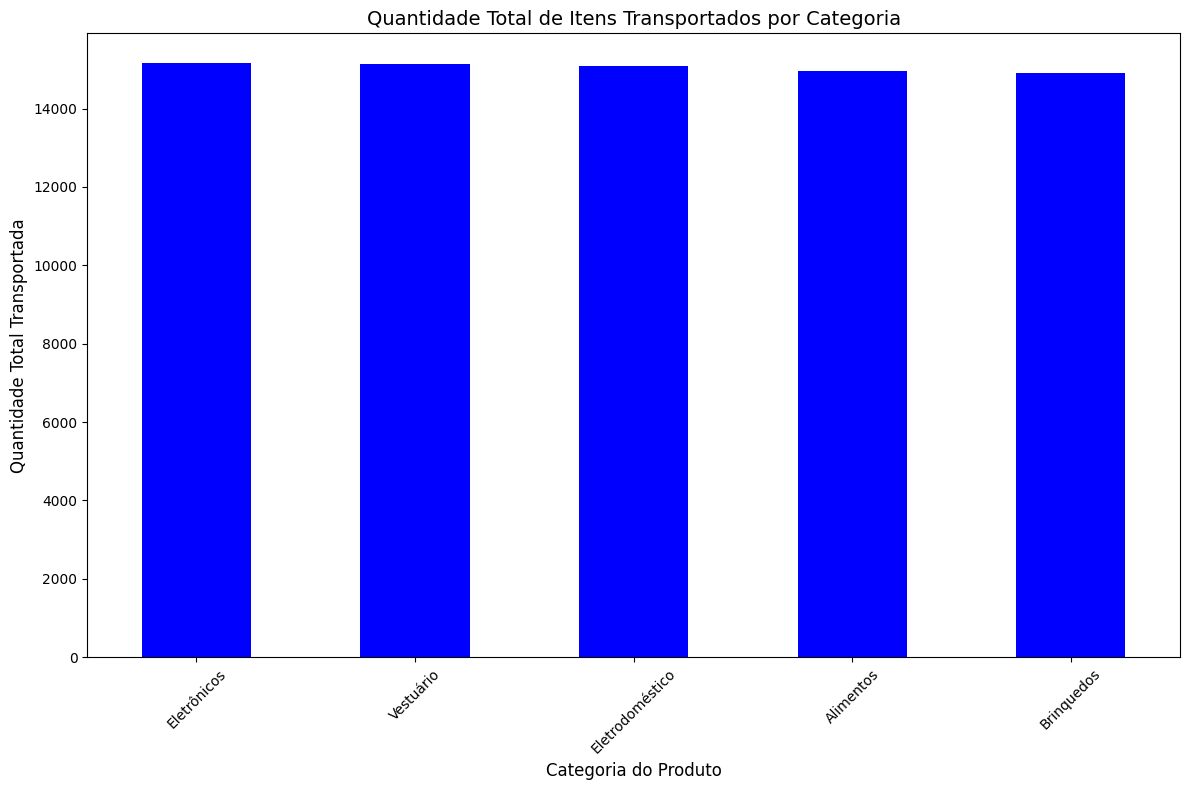

In [27]:
print(
    """
-----------------------------------------------------------------------------------------------------
Gráfico 9: Quantidade total de itens transportados por categoria
Este gráfico mostra o volume total transportado para cada categoria de produto.
Ele ajuda a identificar quais categorias têm maior demanda logística.
-----------------------------------------------------------------------------------------------------
""",
    end="",
)
itens_transportados = (
    df.groupby("categoria_produto")["quantidade_itens"]
    .sum()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 8))
itens_transportados.plot(kind="bar", color="blue")
plt.title("Quantidade Total de Itens Transportados por Categoria", fontsize=14)
plt.xlabel("Categoria do Produto", fontsize=12)
plt.ylabel("Quantidade Total Transportada", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_IMAGES, "quantidade_itens_transportados_por_categoria.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [18]:
print(
    """
-----------------------------------------------------------------------------------------------------
                                            INSIGHTS
-----------------------------------------------------------------------------------------------------
      """,
    end="",
)
print("\n1. Padrões Temporais:")
meses_maior_volume = (
    df.groupby("mes_ano")["id_pedido"].count().nlargest(2).index.tolist()
)
meses_maior_volume_formatados = [mes.strftime("%B/%Y") for mes in meses_maior_volume]
print(f"- Meses com maior volume: {meses_maior_volume_formatados}")
taxa_media_atraso = (df["status_pedido"] == "Atrasado").mean() * 100
print(f"- Taxa média de atraso: {taxa_media_atraso:.1f}%")


print("\n2. Gargalos Operacionais:")
correlacao_ocupacao_tempo = df["percentual_ocupacao_CD"].corr(
    df["tempo_total_processamento_min"]
)
print(
    "- Correlação entre ocupação do CD e tempo de processamento:",
    f"{correlacao_ocupacao_tempo:.2f}",
)
cd_maior_erro = df.groupby("centro_distribuicao")["erro_picking"].mean().idxmax()
print(f"- CD com maior taxa de erro: {cd_maior_erro}")


print("\n3. Fatores de Atraso:")
cd_maior_atraso = df[df["status_pedido"] == "Atrasado"]["centro_distribuicao"].mode()[0]
categoria_mais_atrasada = df[df["status_pedido"] == "Atrasado"][
    "categoria_produto"
].mode()[0]
print(f"- Centro de distribuição com mais atrasos: {cd_maior_atraso}")
print(f"- Categoria mais atrasada: {categoria_mais_atrasada}")


print("4. Maiores Correlações Positivas:")
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs < 1.0]
top_positive_correlations = correlation_pairs.head(5)
seen_pairs = set()
for pair, value in top_positive_correlations.items():
    if (pair[1], pair[0]) not in seen_pairs:
        print(f"- Correlação entre {pair[0]} e {pair[1]}: {value:.2f}")
        seen_pairs.add(pair)


-----------------------------------------------------------------------------------------------------
                                            INSIGHTS
-----------------------------------------------------------------------------------------------------
      
1. Padrões Temporais:
- Meses com maior volume: ['May/2024', 'August/2024']
- Taxa média de atraso: 17.4%

2. Gargalos Operacionais:
- Correlação entre ocupação do CD e tempo de processamento: 0.37
- CD com maior taxa de erro: São Paulo (SP)

3. Fatores de Atraso:
- Centro de distribuição com mais atrasos: Recife (PE)
- Categoria mais atrasada: Vestuário
4. Maiores Correlações Positivas:
- Correlação entre tempo_separacao_min e tempo_total_processamento_min: 0.73
- Correlação entre tempo_separacao_min e percentual_ocupacao_CD: 0.51
- Correlação entre tempo_embalagem_min e tempo_total_processamento_min: 0.42
